# Goal : 
## reproduce magnification bias signal as a function of radius from cluster center, for different source samples, defined by their luminosity function and magnitude cut as measured by https://arxiv.org/pdf/1111.3698.pdf

In [2]:
#import os
#os.environ['CLMM_MODELING_BACKEND'] = 'ct' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import clmm
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from astropy.cosmology import FlatLambdaCDM
import pyccl 

import sys
sys.path.append('../../')
from magnification_library import *

In [3]:
clmm.__version__

'1.0.0'

In [4]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [5]:
#define cluster parameters
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_concentration = np.array((3., 3.5, 4))
cluster_mass = np.array((0.36, 1.7)) *1e14 
cluster_redshift = np.array((0.3, 1.0))

In [6]:
#define source parameters
source_redshift = np.array((3.1, 3.8, 4., 4.8))
mstar = np.array((-20.84, -20.84, -21.00, -20.94))
alpha = np.array((-1.6, -1.56, -1.26, -1.65))
fct = "schechter"

In [7]:
r3d = np.logspace(-2, 2, 1000)

In [8]:
#computation of the magnification per radius and redshift

conc_cl = cluster_concentration[1]
mass_cl = cluster_mass[1]
z_cl = cluster_redshift[1]
z_s = source_redshift[:]

print ("Compute magnification for cluster of mass", mass_cl/1e14, "x 1e14 Msun at redshift z =", z_cl, "with concentration", conc_cl)

mu_2d = np.zeros((r3d.size, z_s.size))

for i in range(z_s.size):
    mu_2d[:,i] = clmm.theory.compute_magnification(r3d, mdelta=mass_cl, cdelta=conc_cl, 
                                        z_cluster=z_cl, z_source=z_s[i], cosmo=cosmo_clmm, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')

Compute magnification for cluster of mass 1.7 x 1e14 Msun at redshift z = 1.0 with concentration 3.5


(0.9, 2.0)

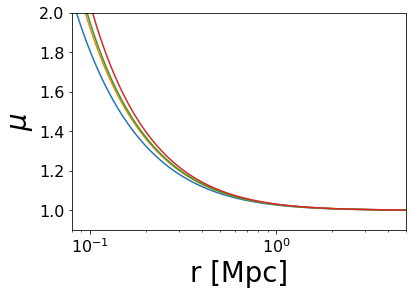

In [9]:
plot_profile(r3d, mu_2d[:,:], '$\\mu$')

plt.yscale('linear')
plt.xlim(0.08, 5)
plt.ylim(0.9, 2)

In [10]:
#define beta slope for each source population

mlim = np.linspace(20, 30, 100)

Mlim1 = mlim_to_Mlim(mlim, z_s[0], cosmo)
Mlim2 = mlim_to_Mlim(mlim, z_s[1], cosmo)
Mlim3 = mlim_to_Mlim(mlim, z_s[2], cosmo)
Mlim4 = mlim_to_Mlim(mlim, z_s[3], cosmo)

Mlim = np.linspace(-23, -18, 100)
mslope_z1 = slope(Mlim, alpha[0], mstar[0], fct=fct)
mslope_z2 = slope(Mlim, alpha[1], mstar[1], fct=fct)
mslope_z3 = slope(Mlim, alpha[2], mstar[2], fct=fct)
mslope_z4 = slope(Mlim, alpha[3], mstar[3], fct=fct)


Text(0, 0.5, '$\\phi$')

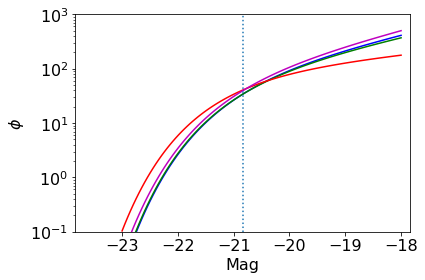

In [11]:
#check what the luminosity function look like
plt.semilogy(Mlim, schechterM(Mlim, 100, alpha[0], mstar[0]), 'b')
plt.semilogy(Mlim, schechterM(Mlim, 100, alpha[1], mstar[1]), 'g')
plt.semilogy(Mlim, schechterM(Mlim, 100, alpha[2], mstar[2]), 'r')
plt.semilogy(Mlim, schechterM(Mlim, 100, alpha[3], mstar[3]), 'm')

plt.axvline(mstar[0], linestyle='dotted')

plt.ylim(1e-1, 1e3)
plt.xlim(mstar[0] - 3, mstar[0] + 3)

plt.xlabel('Mag')
plt.ylabel('$\phi$')

(-1.0, 2.0)

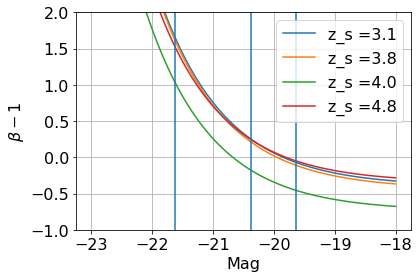

In [12]:
#check what the beta slope look like as a function of magnitude cut

mlim = [24., 25.25, 26.]

Mlim1 = mlim_to_Mlim(mlim, z_s[0], cosmo)
Mlim2 = mlim_to_Mlim(mlim, z_s[1], cosmo)
Mlim3 = mlim_to_Mlim(mlim, z_s[2], cosmo)
Mlim4 = mlim_to_Mlim(mlim, z_s[3], cosmo)


plt.plot(Mlim, 2.5 * mslope_z1 - 1, label = 'z_s ='  + str(z_s[0]))
plt.plot(Mlim, 2.5 * mslope_z2 - 1, label = 'z_s ='  + str(z_s[1]))
plt.plot(Mlim, 2.5 * mslope_z3 - 1, label = 'z_s ='  + str(z_s[2]))
plt.plot(Mlim, 2.5 * mslope_z4 - 1, label = 'z_s ='  + str(z_s[3]))

for i in range(3):
    plt.axvline(Mlim1[i])

plt.xlabel('Mag')
plt.ylabel('$\\beta - 1$');
plt.legend()

plt.grid()
plt.ylim(-1,2)

In [13]:
Mlim[Mlim>Mlim1[0]][0]

-21.585858585858585

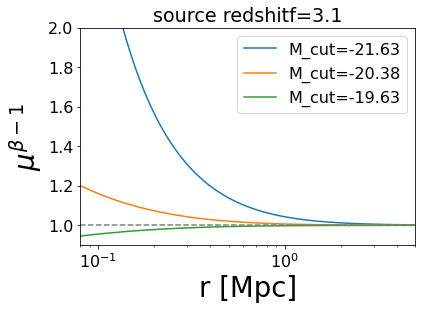

In [14]:
LF_sample = 0

plt.title('source redshitf=' + str(source_redshift[LF_sample]))

plot_profile(r3d, mu_bias(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[0]][0]), '$\\mu^{\\beta - 1}$', label ='M_cut=' + str(round(Mlim1[0],2)))

plot_profile(r3d, mu_bias(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[1]][0]), '$\\mu^{\\beta - 1}$', label ='M_cut=' + str(round(Mlim1[1],2)))

plot_profile(r3d, mu_bias(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[2]][0]), '$\\mu^{\\beta - 1}$', label ='M_cut=' + str(round(Mlim1[2],2)))



plt.axhline(1,linestyle='dashed', color='grey')
plt.yscale('linear')
plt.xlim(0.08, 5)
plt.ylim(0.9, 2)

plt.legend()

In [15]:
#define estimator for the density contrast due to magnification bias
def estimator(mu, beta):
    w =  mu**(beta - 1) - 1
    return w

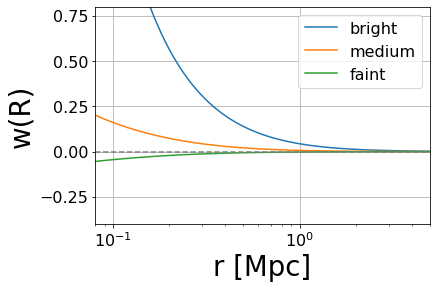

In [16]:
LF_sample = 0

plot_profile(r3d, estimator(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[0]][0]), 'w(R)', label ='bright')

plot_profile(r3d, estimator(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[1]][0]), 'w(R)', label ='medium')

plot_profile(r3d, estimator(mu_2d[:,LF_sample], 2.5 * mslope_z1[Mlim>Mlim1[2]][0]), 'w(R)', label ='faint')


plt.axhline(0,linestyle='dashed', color='grey')
plt.yscale('linear')
plt.xlim(0.08, 5)
plt.ylim(-0.4 ,0.8)

plt.legend()
plt.grid()